In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load the dataset (Ensure the dataset is uploaded in Colab)
df = pd.read_csv('stock_data.csv')  # Replace with your dataset file name

# Check for missing values
print(df.isnull().sum())  # Check for missing values

# Handle missing values (if any)
df.fillna(method='ffill', inplace=True)  # Forward fill to fill missing values

# Check for duplicates
print(f"Duplicate Rows: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)  # Drop duplicates

# Outlier handling - Here we'll remove extreme outliers (adjust based on your dataset)
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['Close'] >= (Q1 - 1.5 * IQR)) & (df['Close'] <= (Q3 + 1.5 * IQR))]

# Feature Scaling (MinMaxScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Close']].values.reshape(-1, 1))

# Check scaled data
print(scaled_data[:5])  # Show first 5 scaled values

Open               0
Close              0
High               0
Low                0
Volume             0
RSI                0
MACD               0
Bollinger_Upper    0
Bollinger_Lower    0
Sentiment_Score    0
GDP_Growth         0
Inflation_Rate     0
Target             0
dtype: int64
Duplicate Rows: 0
[[0.37680239]
 [0.94997217]
 [0.72810169]
 [0.60596728]
 [0.16160123]]


<ipython-input-2-8b0c8c841ddb>:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # Forward fill to fill missing values


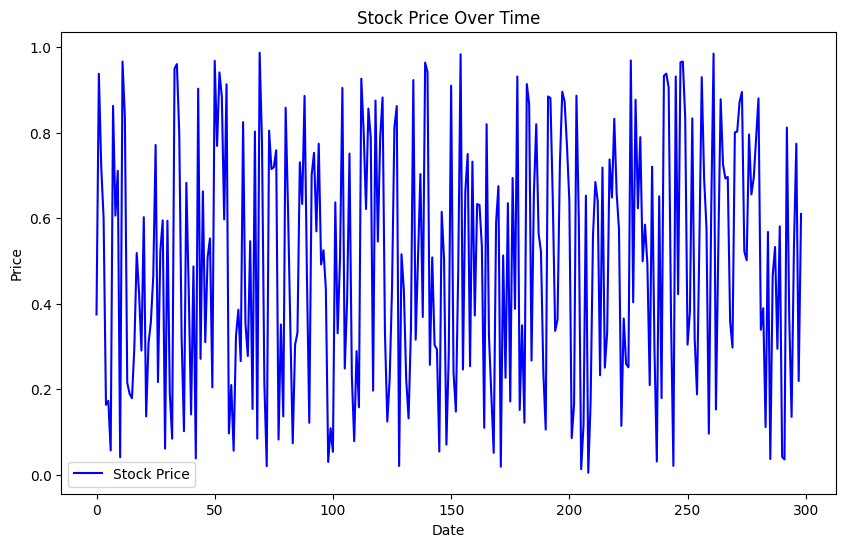

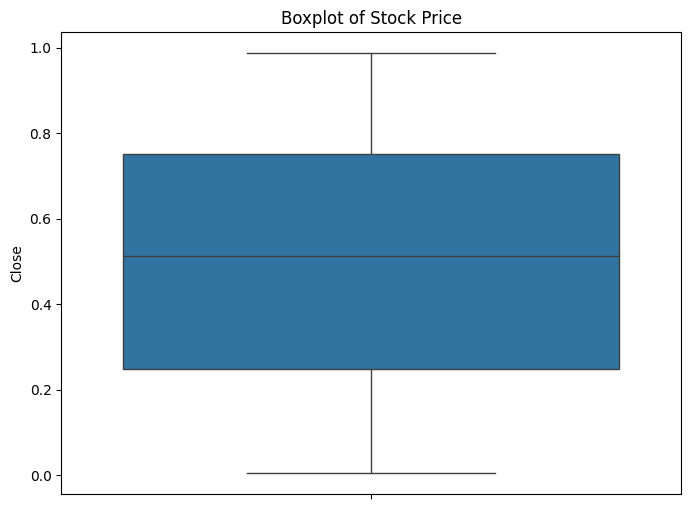

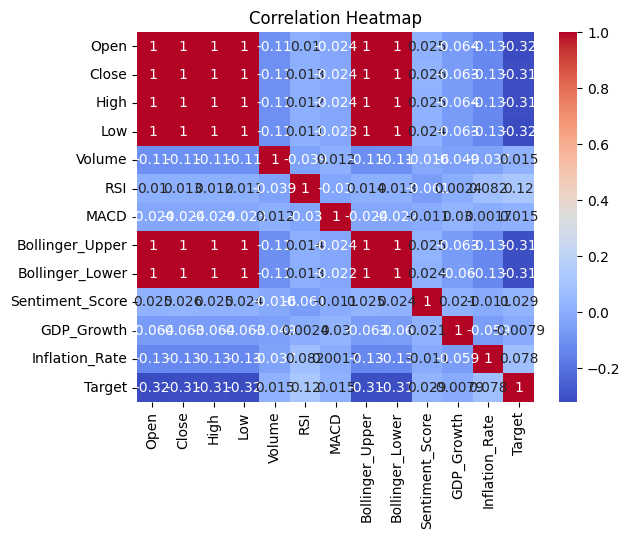

In [3]:
# Import necessary libraries for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the closing stock price over time
plt.figure(figsize=(10, 6))
plt.plot(df['Close'], color='blue', label='Stock Price')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Boxplot to detect outliers in 'Close' prices
plt.figure(figsize=(8, 6))
sns.boxplot(df['Close'])
plt.title('Boxplot of Stock Price')
plt.show()

# Check correlation (if using other features, like volume or indicators)
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [4]:
import numpy as np

# Function to create sequences from the data for LSTM input
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])  # X will hold past sequence (e.g., last 60 days)
        y.append(data[i, 0])  # y will be the next value (next day's closing price)
    X = np.array(X)
    y = np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # Reshaping for LSTM input (3D)
    return X, y

# Create sequences with a length of 60 (60 days of stock prices)
X, y = create_sequences(scaled_data, seq_length=60)
print(X.shape, y.shape)  # Check the shape of the data

(239, 60, 1) (239,)


In [5]:
# Import necessary libraries for building LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Function to build the LSTM model
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(units=1))  # Output layer to predict the next price
    model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model
    return model

# Build the model and display the summary
model = build_lstm_model((X.shape[1], 1))
model.summary()  # Display model architecture

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.2437
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1117
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0977
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.1035
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0899
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0803
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0873
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0861
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0903
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0908


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step


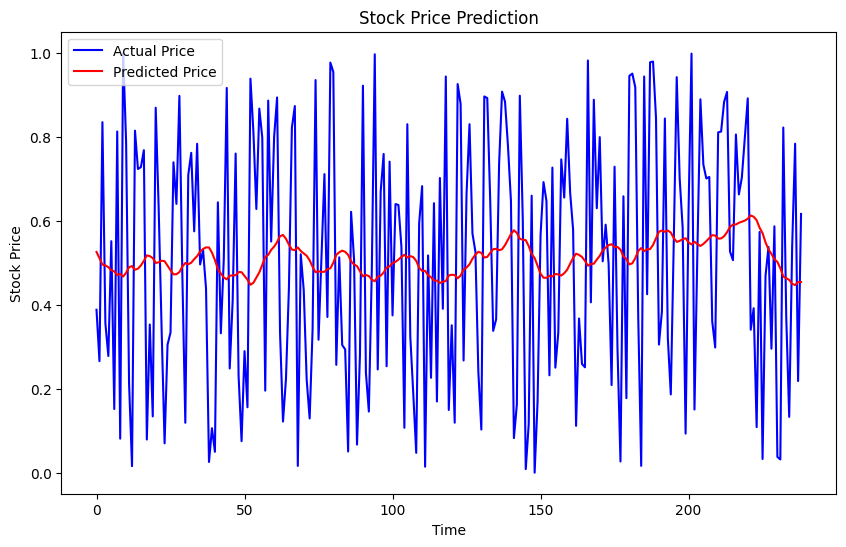

RMSE: 0.2935621351049004


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
# Train the model
model.fit(X, y, epochs=10, batch_size=32)

# Save the model after training
model.save('lstm_model.h5')  # Save the trained model as lstm_model.h5

# Make predictions on the training data
predictions = model.predict(X)

# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y, color='blue', label='Actual Price')
plt.plot(predictions, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Calculate RMSE (Root Mean Squared Error) for model evaluation
from sklearn.metrics import mean_squared_error
import math
rmse = math.sqrt(mean_squared_error(y, predictions))
print(f"RMSE: {rmse}")

# Download the model file
from google.colab import files
files.download('lstm_model.h5')  # This will download the saved model file to your local machine